<a href="https://colab.research.google.com/github/navoday01/ResNet5M-CIFAR10/blob/main/models/DL_Mini_Project_Try_2_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries:
import torch
import torchvision
from torch import nn
from tqdm import tqdm
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torchvision.utils import make_grid

In [2]:
# Defining transforms for training and testing data:
transform = transforms.Compose(
		[transforms.RandomCrop(32, padding=4),
		 transforms.RandomHorizontalFlip(),
		 transforms.ToTensor(),
		 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Downloading training and testing data:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Initializing batch size:
batch=32

In [5]:
# Creating training and testing dataloaders:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


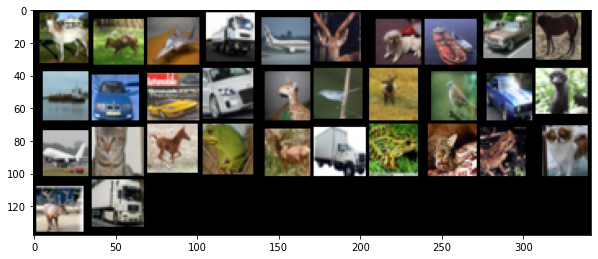

In [6]:
#visualizing training data

data_stats = [(0.5,0.5,0.5),(0.5,0.5,0.5)]

def denormalize(images,means,stdDev):
    means = torch.tensor(means).reshape(1,3,1,1)
    stdDev = torch.tensor(means).reshape(1,3,1,1)
    return(images*stdDev+means)

def showPreview(dl):

    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(10,10))
        ax.imshow(make_grid(denormalize(images,*data_stats),10).permute(1,2,0))
        break

showPreview(train_loader)  

In [7]:
# Getting class names from the dataset:
classes = trainset.class_to_idx

In [8]:
# Defining basic block:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1,dropout =0.2):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)    
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(p = dropout)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [9]:
# Defining Resnet architecture:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,dropout =0.2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p = dropout)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.dropout(F.relu(self.bn1(self.conv1(x)))) 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [10]:
# Creating lists for train and test loss and accuracies:
train_losses = []
train_acc = []
test_losses_l1 = []
test_acc_l1 = []

In [11]:
# Function train:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct = 0
  processed = 0
  criterion= nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss  = criterion(y_pred, target)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_acc.append(100*correct/processed)

In [12]:
# Function test:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion= nn.CrossEntropyLoss().to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

In [13]:
# Geting cpu or gpu device for training:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [14]:
model = ResNet(BasicBlock, [2,3,2,2]).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [15]:
# Displaying number of trainable parameters:
sum(p.numel() for p in model.parameters() if p.requires_grad)

4479946

In [16]:
# Displaying summary of the model:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
           Dropout-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [17]:
# Initializing batch size Learning Rate annd moment:
epochs =65
LR = 0.01
moment = 0.9

In [18]:
# Training the model over training and testing datasets:

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=moment)
scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=epochs)

for epoch in range(epochs):
    print(f'Epoch: {epoch} Learning_Rate {scheduler.get_lr()}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1587: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0 Learning_Rate [0.0040000000000000036]


Loss=1.2184315919876099 Batch_id=1562 Accuracy=42.09: 100%|██████████| 1563/1563 [00:54<00:00, 28.56it/s]



Test set: Average loss: 0.0401, Accuracy: 5327/10000 (53.2700%)

Epoch: 1 Learning_Rate [0.004690436303309994]


Loss=0.9453418254852295 Batch_id=1562 Accuracy=61.09: 100%|██████████| 1563/1563 [00:53<00:00, 29.01it/s]



Test set: Average loss: 0.0291, Accuracy: 6720/10000 (67.2000%)

Epoch: 2 Learning_Rate [0.006741882617867956]


Loss=0.834365725517273 Batch_id=1562 Accuracy=68.73: 100%|██████████| 1563/1563 [00:53<00:00, 29.15it/s]



Test set: Average loss: 0.0247, Accuracy: 7285/10000 (72.8500%)

Epoch: 3 Learning_Rate [0.010095322568262968]


Loss=1.5413126945495605 Batch_id=1562 Accuracy=73.02: 100%|██████████| 1563/1563 [00:54<00:00, 28.66it/s]



Test set: Average loss: 0.0208, Accuracy: 7699/10000 (76.9900%)

Epoch: 4 Learning_Rate [0.014654283792714912]


Loss=0.5301264524459839 Batch_id=1562 Accuracy=75.85: 100%|██████████| 1563/1563 [00:54<00:00, 28.58it/s]



Test set: Average loss: 0.0204, Accuracy: 7800/10000 (78.0000%)

Epoch: 5 Learning_Rate [0.0202876132772761]


Loss=0.8633145689964294 Batch_id=1562 Accuracy=78.19: 100%|██████████| 1563/1563 [00:54<00:00, 28.55it/s]



Test set: Average loss: 0.0178, Accuracy: 8054/10000 (80.5400%)

Epoch: 6 Learning_Rate [0.026833250389252883]


Loss=0.6283314824104309 Batch_id=1562 Accuracy=80.23: 100%|██████████| 1563/1563 [00:55<00:00, 27.93it/s]



Test set: Average loss: 0.0170, Accuracy: 8186/10000 (81.8600%)

Epoch: 7 Learning_Rate [0.03410288906654518]


Loss=0.34954631328582764 Batch_id=1562 Accuracy=81.57: 100%|██████████| 1563/1563 [00:54<00:00, 28.80it/s]



Test set: Average loss: 0.0153, Accuracy: 8343/10000 (83.4300%)

Epoch: 8 Learning_Rate [0.041887395040205146]


Loss=0.6647899746894836 Batch_id=1562 Accuracy=82.91: 100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]



Test set: Average loss: 0.0149, Accuracy: 8394/10000 (83.9400%)

Epoch: 9 Learning_Rate [0.04996282224658489]


Loss=0.38480332493782043 Batch_id=1562 Accuracy=84.34: 100%|██████████| 1563/1563 [00:54<00:00, 28.55it/s]



Test set: Average loss: 0.0134, Accuracy: 8542/10000 (85.4200%)

Epoch: 10 Learning_Rate [0.05809685534785018]


Loss=0.26396894454956055 Batch_id=1562 Accuracy=85.34: 100%|██████████| 1563/1563 [00:55<00:00, 28.34it/s]



Test set: Average loss: 0.0135, Accuracy: 8517/10000 (85.1700%)

Epoch: 11 Learning_Rate [0.06605549302127442]


Loss=0.26554498076438904 Batch_id=1562 Accuracy=86.10: 100%|██████████| 1563/1563 [00:53<00:00, 28.99it/s]



Test set: Average loss: 0.0127, Accuracy: 8609/10000 (86.0900%)

Epoch: 12 Learning_Rate [0.07360977975124833]


Loss=0.670301079750061 Batch_id=1562 Accuracy=87.28: 100%|██████████| 1563/1563 [00:53<00:00, 28.95it/s]



Test set: Average loss: 0.0139, Accuracy: 8489/10000 (84.8900%)

Epoch: 13 Learning_Rate [0.08054239246260576]


Loss=0.12453728169202805 Batch_id=1562 Accuracy=87.77: 100%|██████████| 1563/1563 [00:53<00:00, 28.96it/s]



Test set: Average loss: 0.0122, Accuracy: 8683/10000 (86.8300%)

Epoch: 14 Learning_Rate [0.08665389250981717]


Loss=0.41963836550712585 Batch_id=1562 Accuracy=88.45: 100%|██████████| 1563/1563 [00:58<00:00, 26.80it/s]



Test set: Average loss: 0.0118, Accuracy: 8758/10000 (87.5800%)

Epoch: 15 Learning_Rate [0.09176846316370442]


Loss=0.04585855081677437 Batch_id=1562 Accuracy=89.02: 100%|██████████| 1563/1563 [00:59<00:00, 26.45it/s]



Test set: Average loss: 0.0107, Accuracy: 8833/10000 (88.3300%)

Epoch: 16 Learning_Rate [0.09573896753863052]


Loss=0.5033013820648193 Batch_id=1562 Accuracy=89.71: 100%|██████████| 1563/1563 [00:54<00:00, 28.54it/s]



Test set: Average loss: 0.0109, Accuracy: 8864/10000 (88.6400%)

Epoch: 17 Learning_Rate [0.09845118145280796]


Loss=0.5647077560424805 Batch_id=1562 Accuracy=90.15: 100%|██████████| 1563/1563 [00:54<00:00, 28.67it/s]



Test set: Average loss: 0.0105, Accuracy: 8903/10000 (89.0300%)

Epoch: 18 Learning_Rate [0.09982707945004128]


Loss=0.07976207882165909 Batch_id=1562 Accuracy=90.51: 100%|██████████| 1563/1563 [00:53<00:00, 29.08it/s]



Test set: Average loss: 0.0111, Accuracy: 8825/10000 (88.2500%)

Epoch: 19 Learning_Rate [0.09997020714672541]


Loss=0.36034253239631653 Batch_id=1562 Accuracy=91.08: 100%|██████████| 1563/1563 [00:53<00:00, 29.05it/s]



Test set: Average loss: 0.0100, Accuracy: 8910/10000 (89.1000%)

Epoch: 20 Learning_Rate [0.0997320773064547]


Loss=0.35337477922439575 Batch_id=1562 Accuracy=91.60: 100%|██████████| 1563/1563 [00:53<00:00, 29.00it/s]



Test set: Average loss: 0.0103, Accuracy: 8893/10000 (88.9300%)

Epoch: 21 Learning_Rate [0.09925695242304589]


Loss=0.3639674782752991 Batch_id=1562 Accuracy=92.10: 100%|██████████| 1563/1563 [00:54<00:00, 28.67it/s]



Test set: Average loss: 0.0093, Accuracy: 9024/10000 (90.2400%)

Epoch: 22 Learning_Rate [0.09854709668293912]


Loss=0.18152040243148804 Batch_id=1562 Accuracy=92.34: 100%|██████████| 1563/1563 [00:53<00:00, 29.13it/s]



Test set: Average loss: 0.0098, Accuracy: 8956/10000 (89.5600%)

Epoch: 23 Learning_Rate [0.09760589287200253]


Loss=0.1572881042957306 Batch_id=1562 Accuracy=92.73: 100%|██████████| 1563/1563 [00:53<00:00, 29.04it/s]



Test set: Average loss: 0.0102, Accuracy: 8952/10000 (89.5200%)

Epoch: 24 Learning_Rate [0.0964378262550171]


Loss=0.02531849965453148 Batch_id=1562 Accuracy=93.01: 100%|██████████| 1563/1563 [00:53<00:00, 29.18it/s]



Test set: Average loss: 0.0096, Accuracy: 9014/10000 (90.1400%)

Epoch: 25 Learning_Rate [0.09504846320134738]


Loss=0.11612506955862045 Batch_id=1562 Accuracy=93.22: 100%|██████████| 1563/1563 [00:55<00:00, 28.38it/s]



Test set: Average loss: 0.0098, Accuracy: 9009/10000 (90.0900%)

Epoch: 26 Learning_Rate [0.09344442465865659]


Loss=0.041871458292007446 Batch_id=1562 Accuracy=93.74: 100%|██████████| 1563/1563 [00:53<00:00, 29.02it/s]



Test set: Average loss: 0.0093, Accuracy: 9042/10000 (90.4200%)

Epoch: 27 Learning_Rate [0.09163335460107579]


Loss=0.050342440605163574 Batch_id=1562 Accuracy=93.91: 100%|██████████| 1563/1563 [00:54<00:00, 28.91it/s]



Test set: Average loss: 0.0089, Accuracy: 9095/10000 (90.9500%)

Epoch: 28 Learning_Rate [0.08962388360218614]


Loss=0.04139097407460213 Batch_id=1562 Accuracy=94.06: 100%|██████████| 1563/1563 [00:55<00:00, 28.37it/s]



Test set: Average loss: 0.0095, Accuracy: 9037/10000 (90.3700%)

Epoch: 29 Learning_Rate [0.08742558770640542]


Loss=0.02461562119424343 Batch_id=1562 Accuracy=94.35: 100%|██████████| 1563/1563 [00:54<00:00, 28.80it/s]



Test set: Average loss: 0.0098, Accuracy: 9023/10000 (90.2300%)

Epoch: 30 Learning_Rate [0.08504894279477551]


Loss=0.9392337799072266 Batch_id=1562 Accuracy=94.52: 100%|██████████| 1563/1563 [00:53<00:00, 28.96it/s]



Test set: Average loss: 0.0093, Accuracy: 9062/10000 (90.6200%)

Epoch: 31 Learning_Rate [0.08250527466261848]


Loss=1.000580072402954 Batch_id=1562 Accuracy=94.94: 100%|██████████| 1563/1563 [00:54<00:00, 28.81it/s]



Test set: Average loss: 0.0099, Accuracy: 9030/10000 (90.3000%)

Epoch: 32 Learning_Rate [0.07980670504696417]


Loss=0.18042749166488647 Batch_id=1562 Accuracy=95.18: 100%|██████████| 1563/1563 [00:56<00:00, 27.76it/s]



Test set: Average loss: 0.0091, Accuracy: 9098/10000 (90.9800%)

Epoch: 33 Learning_Rate [0.07696609386095307]


Loss=0.12387190759181976 Batch_id=1562 Accuracy=95.36: 100%|██████████| 1563/1563 [00:54<00:00, 28.91it/s]



Test set: Average loss: 0.0100, Accuracy: 9056/10000 (90.5600%)

Epoch: 34 Learning_Rate [0.07399697791049374]


Loss=0.03769265115261078 Batch_id=1562 Accuracy=95.49: 100%|██████████| 1563/1563 [00:53<00:00, 28.96it/s]



Test set: Average loss: 0.0089, Accuracy: 9135/10000 (91.3500%)

Epoch: 35 Learning_Rate [0.07091350638521811]


Loss=0.006567742209881544 Batch_id=1562 Accuracy=95.72: 100%|██████████| 1563/1563 [00:54<00:00, 28.45it/s]



Test set: Average loss: 0.0087, Accuracy: 9164/10000 (91.6400%)

Epoch: 36 Learning_Rate [0.06773037343114938]


Loss=0.01067080907523632 Batch_id=1562 Accuracy=96.00: 100%|██████████| 1563/1563 [00:54<00:00, 28.82it/s]



Test set: Average loss: 0.0087, Accuracy: 9161/10000 (91.6100%)

Epoch: 37 Learning_Rate [0.06446274812640448]


Loss=0.11916317045688629 Batch_id=1562 Accuracy=96.03: 100%|██████████| 1563/1563 [00:54<00:00, 28.65it/s]



Test set: Average loss: 0.0091, Accuracy: 9133/10000 (91.3300%)

Epoch: 38 Learning_Rate [0.06112620219362893]


Loss=0.3034539520740509 Batch_id=1562 Accuracy=96.20: 100%|██████████| 1563/1563 [00:54<00:00, 28.58it/s]



Test set: Average loss: 0.0088, Accuracy: 9147/10000 (91.4700%)

Epoch: 39 Learning_Rate [0.0577366357936471]


Loss=0.04909631982445717 Batch_id=1562 Accuracy=96.44: 100%|██████████| 1563/1563 [00:55<00:00, 28.29it/s]



Test set: Average loss: 0.0089, Accuracy: 9178/10000 (91.7800%)

Epoch: 40 Learning_Rate [0.054310201753955]


Loss=0.05874983221292496 Batch_id=1562 Accuracy=96.64: 100%|██████████| 1563/1563 [00:54<00:00, 28.53it/s]



Test set: Average loss: 0.0087, Accuracy: 9189/10000 (91.8900%)

Epoch: 41 Learning_Rate [0.05086322859314125]


Loss=0.3185579180717468 Batch_id=1562 Accuracy=96.88: 100%|██████████| 1563/1563 [00:54<00:00, 28.76it/s]



Test set: Average loss: 0.0088, Accuracy: 9195/10000 (91.9500%)

Epoch: 42 Learning_Rate [0.0474121427080601]


Loss=0.009259154088795185 Batch_id=1562 Accuracy=96.98: 100%|██████████| 1563/1563 [00:54<00:00, 28.87it/s]



Test set: Average loss: 0.0087, Accuracy: 9224/10000 (92.2400%)

Epoch: 43 Learning_Rate [0.04397339009456991]


Loss=0.15716813504695892 Batch_id=1562 Accuracy=97.18: 100%|██████████| 1563/1563 [00:55<00:00, 28.26it/s]



Test set: Average loss: 0.0093, Accuracy: 9214/10000 (92.1400%)

Epoch: 44 Learning_Rate [0.04056335797487326]


Loss=0.012487657368183136 Batch_id=1562 Accuracy=97.36: 100%|██████████| 1563/1563 [00:54<00:00, 28.72it/s]



Test set: Average loss: 0.0090, Accuracy: 9238/10000 (92.3800%)

Epoch: 45 Learning_Rate [0.03719829670494066]


Loss=0.25633862614631653 Batch_id=1562 Accuracy=97.60: 100%|██████████| 1563/1563 [00:53<00:00, 28.95it/s]



Test set: Average loss: 0.0090, Accuracy: 9242/10000 (92.4200%)

Epoch: 46 Learning_Rate [0.03389424233416384]


Loss=0.0051224431954324245 Batch_id=1562 Accuracy=97.71: 100%|██████████| 1563/1563 [00:54<00:00, 28.92it/s]



Test set: Average loss: 0.0088, Accuracy: 9231/10000 (92.3100%)

Epoch: 47 Learning_Rate [0.030666940186277653]


Loss=0.002314257435500622 Batch_id=1562 Accuracy=97.90: 100%|██████████| 1563/1563 [00:53<00:00, 29.26it/s]



Test set: Average loss: 0.0093, Accuracy: 9238/10000 (92.3800%)

Epoch: 48 Learning_Rate [0.02753176982572212]


Loss=0.05058862641453743 Batch_id=1562 Accuracy=98.14: 100%|██████████| 1563/1563 [00:54<00:00, 28.72it/s]



Test set: Average loss: 0.0096, Accuracy: 9209/10000 (92.0900%)

Epoch: 49 Learning_Rate [0.0245036717670141]


Loss=0.10121101886034012 Batch_id=1562 Accuracy=98.30: 100%|██████████| 1563/1563 [00:54<00:00, 28.94it/s]



Test set: Average loss: 0.0091, Accuracy: 9243/10000 (92.4300%)

Epoch: 50 Learning_Rate [0.021597076276391566]


Loss=0.0232356246560812 Batch_id=1562 Accuracy=98.39: 100%|██████████| 1563/1563 [00:54<00:00, 28.82it/s]



Test set: Average loss: 0.0097, Accuracy: 9205/10000 (92.0500%)

Epoch: 51 Learning_Rate [0.0188258346050237]


Loss=0.0018940736772492528 Batch_id=1562 Accuracy=98.58: 100%|██████████| 1563/1563 [00:54<00:00, 28.75it/s]



Test set: Average loss: 0.0090, Accuracy: 9265/10000 (92.6500%)

Epoch: 52 Learning_Rate [0.016203152981491113]


Loss=0.05928141996264458 Batch_id=1562 Accuracy=98.63: 100%|██████████| 1563/1563 [00:54<00:00, 28.92it/s]



Test set: Average loss: 0.0095, Accuracy: 9275/10000 (92.7500%)

Epoch: 53 Learning_Rate [0.013741529678092617]


Loss=0.005736132152378559 Batch_id=1562 Accuracy=98.91: 100%|██████████| 1563/1563 [00:54<00:00, 28.43it/s]



Test set: Average loss: 0.0090, Accuracy: 9288/10000 (92.8800%)

Epoch: 54 Learning_Rate [0.011452695450885978]


Loss=0.00982111506164074 Batch_id=1562 Accuracy=98.97: 100%|██████████| 1563/1563 [00:54<00:00, 28.68it/s]



Test set: Average loss: 0.0094, Accuracy: 9278/10000 (92.7800%)

Epoch: 55 Learning_Rate [0.009347557637293264]


Loss=0.002273584483191371 Batch_id=1562 Accuracy=99.08: 100%|██████████| 1563/1563 [00:54<00:00, 28.73it/s]



Test set: Average loss: 0.0085, Accuracy: 9318/10000 (93.1800%)

Epoch: 56 Learning_Rate [0.007436148177670761]


Loss=0.0018026743782684207 Batch_id=1562 Accuracy=99.16: 100%|██████████| 1563/1563 [00:54<00:00, 28.65it/s]



Test set: Average loss: 0.0091, Accuracy: 9309/10000 (93.0900%)

Epoch: 57 Learning_Rate [0.005727575808544641]


Loss=0.009600612334907055 Batch_id=1562 Accuracy=99.13: 100%|██████████| 1563/1563 [00:55<00:00, 28.41it/s]



Test set: Average loss: 0.0091, Accuracy: 9315/10000 (93.1500%)

Epoch: 58 Learning_Rate [0.00422998265533339]


Loss=0.0012140468461439013 Batch_id=1562 Accuracy=99.34: 100%|██████████| 1563/1563 [00:54<00:00, 28.78it/s]



Test set: Average loss: 0.0088, Accuracy: 9350/10000 (93.5000%)

Epoch: 59 Learning_Rate [0.0029505054314122557]


Loss=0.001362233655527234 Batch_id=1562 Accuracy=99.39: 100%|██████████| 1563/1563 [00:54<00:00, 28.43it/s]



Test set: Average loss: 0.0090, Accuracy: 9331/10000 (93.3100%)

Epoch: 60 Learning_Rate [0.0018952414284239454]


Loss=0.00019194401102140546 Batch_id=1562 Accuracy=99.39: 100%|██████████| 1563/1563 [00:54<00:00, 28.44it/s]



Test set: Average loss: 0.0091, Accuracy: 9335/10000 (93.3500%)

Epoch: 61 Learning_Rate [0.0010692194599072938]


Loss=0.053236544132232666 Batch_id=1562 Accuracy=99.45: 100%|██████████| 1563/1563 [00:55<00:00, 28.04it/s]



Test set: Average loss: 0.0092, Accuracy: 9330/10000 (93.3000%)

Epoch: 62 Learning_Rate [0.00047637589671063827]


Loss=0.0020568042527884245 Batch_id=1562 Accuracy=99.38: 100%|██████████| 1563/1563 [00:54<00:00, 28.52it/s]



Test set: Average loss: 0.0091, Accuracy: 9313/10000 (93.1300%)

Epoch: 63 Learning_Rate [0.00011953590839208394]


Loss=0.0020177443511784077 Batch_id=1562 Accuracy=99.44: 100%|██████████| 1563/1563 [00:54<00:00, 28.59it/s]



Test set: Average loss: 0.0089, Accuracy: 9361/10000 (93.6100%)

Epoch: 64 Learning_Rate [4e-07]


Loss=0.005041799508035183 Batch_id=1562 Accuracy=99.47: 100%|██████████| 1563/1563 [00:55<00:00, 27.97it/s]



Test set: Average loss: 0.0091, Accuracy: 9332/10000 (93.3200%)



In [19]:
#converting from cuda tensors to .cpu()

arr_train=np.array(torch.Tensor(train_losses).cpu())

arr_test=np.array(torch.Tensor(test_losses_l1).cpu())

arr_train_acc=np.array(torch.Tensor(train_acc).cpu())

arr_test_acc=np.array(torch.Tensor(test_acc_l1).cpu())

In [20]:
# Getting the train loss for the last batch for every epoch:
arr_train1 =[]
for i in range(len(arr_train)):
  if (i%1563) == 0:
    arr_train1.append(arr_train[i])

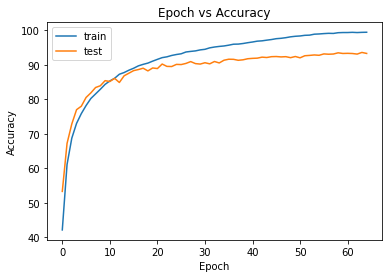

In [21]:
# Plotting the accuracy:
plt.plot(arr_train_acc)
plt.plot(arr_test_acc)
plt.legend(["train","test"])
plt.title("Epoch vs Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

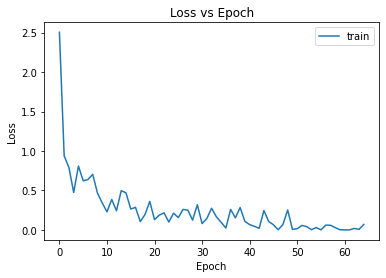

In [22]:
# Printing train  and test loss:
plt.plot(arr_train1 )
plt.legend(["train"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

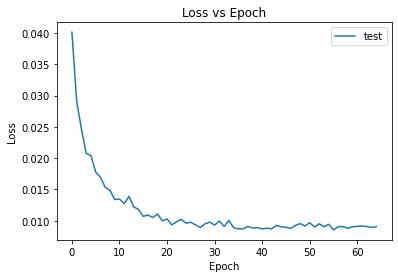

In [23]:

plt.plot(arr_test)
plt.legend(["test"])
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [24]:
# Save random initial weights:
#torch.save(model.state_dict(), 'DLMiniProjectTry2.pt')

model.cpu()
model_scripted = torch.jit.script(model)
model_scripted.save('ResNetSGD.pt')
print("Saved Model")

Saved Model
